**An Exploratory Analysis Into New York's Housing Market**

*Introduction:*
Preliminary exploratory data analysis:

Methods:

Expected outcomes and significance:


**Introduction:**

New York is one of the most renowned places in the world, celebrated for its abundance of attractions and vibrant environment. However, housing in the state can be expensive, posing a significant challenge for residents and newcomers. The *New York Housing Market* dataset available on Kaggle provides a comprehensive view of the real estate data in New York City. Using the New York Housing Market dataset, this project will look at how the different cities in New York affect the price of homes relative to their number of bedrooms, bathrooms, and square footage. The question we will be answering is **"What is the relationship between price and square footage of properties in the cities of New York?"**

**Preliminary Exploratory Data Analysis:**

In [51]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [52]:
set.seed(123)

In [53]:
newyork_housing <- read_csv("data/NY-House-Dataset.csv")
head(newyork_housing)

Rows: 4801 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): BROKERTITLE, TYPE, ADDRESS, STATE, MAIN_ADDRESS, ADMINISTRATIVE_AR...
dbl  (6): PRICE, BEDS, BATH, PROPERTYSQFT, LATITUDE, LONGITUDE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,3.15e+05,2,2.000000,1400,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, NY 10022, USA",40.76125,-73.97448
Brokered by Serhant,Condo for sale,1.95e+08,7,10.000000,17545,Central Park Tower Penthouse-217 W 57th New York St Unit Penthouse,"New York, NY 10019","Central Park Tower Penthouse-217 W 57th New York St Unit PenthouseNew York, NY 10019",United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.76639,-73.98099
Brokered by Sowae Corp,House for sale,2.60e+05,4,2.000000,2015,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.54181,-74.19611
Brokered by COMPASS,Condo for sale,6.90e+04,3,1.000000,445,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.76140,-73.97461
Brokered by Sotheby's International Realty - East Side Manhattan Brokerage,Townhouse for sale,5.50e+07,7,2.373861,14175,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.76722,-73.96986
Brokered by Sowae Corp,House for sale,6.90e+05,5,2.000000,4004,584 Park Pl,"Brooklyn, NY 11238","584 Park PlBrooklyn, NY 11238",United States,New York,Kings County,Brooklyn,Park Place,"584 Park Pl, Brooklyn, NY 11238, USA",40.67436,-73.95872


In [54]:
newyork_filtered_data <- newyork_housing|>
        select(TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE) |>
        filter(PROPERTYSQFT < 20000, PRICE < 10000000)
    
head(newyork_filtered_data)

TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Condo for sale,315000,2,2,1400.000,"New York, NY 10022"
House for sale,260000,4,2,2015.000,"Staten Island, NY 10312"
Condo for sale,69000,3,1,445.000,"Manhattan, NY 10022"
House for sale,690000,5,2,4004.000,"Brooklyn, NY 11238"
Condo for sale,899500,2,2,2184.208,"New York, NY 10027"
Co-op for sale,265000,1,1,750.000,"Bronx, NY 10473"


In [55]:
newyork_tidy <- newyork_filtered_data |>
                separate(STATE, c('CITY', 'NUMBER'), sep = ",") |>
                filter(TYPE != "Pending") |> 
                select(TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,CITY) |> 
                mutate(BATH = as.integer(BATH))
head(newyork_tidy)

TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,CITY
<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Condo for sale,315000,2,2,1400.000,New York
House for sale,260000,4,2,2015.000,Staten Island
Condo for sale,69000,3,1,445.000,Manhattan
House for sale,690000,5,2,4004.000,Brooklyn
Condo for sale,899500,2,2,2184.208,New York
Co-op for sale,265000,1,1,750.000,Bronx


In [56]:
newyork_tidy_sample <- head(newyork_tidy, n = 50)
newyork_tidy_sample

TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,CITY
<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Condo for sale,315000,2,2,1400.000,New York
House for sale,260000,4,2,2015.000,Staten Island
Condo for sale,69000,3,1,445.000,Manhattan
House for sale,690000,5,2,4004.000,Brooklyn
Condo for sale,899500,2,2,2184.208,New York
⋮,⋮,⋮,⋮,⋮,⋮
Condo for sale,329000,2,1,837.000,Staten Island
Multi-family home for sale,889000,2,2,1520.000,Staten Island
Multi-family home for sale,769000,2,2,2184.208,Richmond Hill South


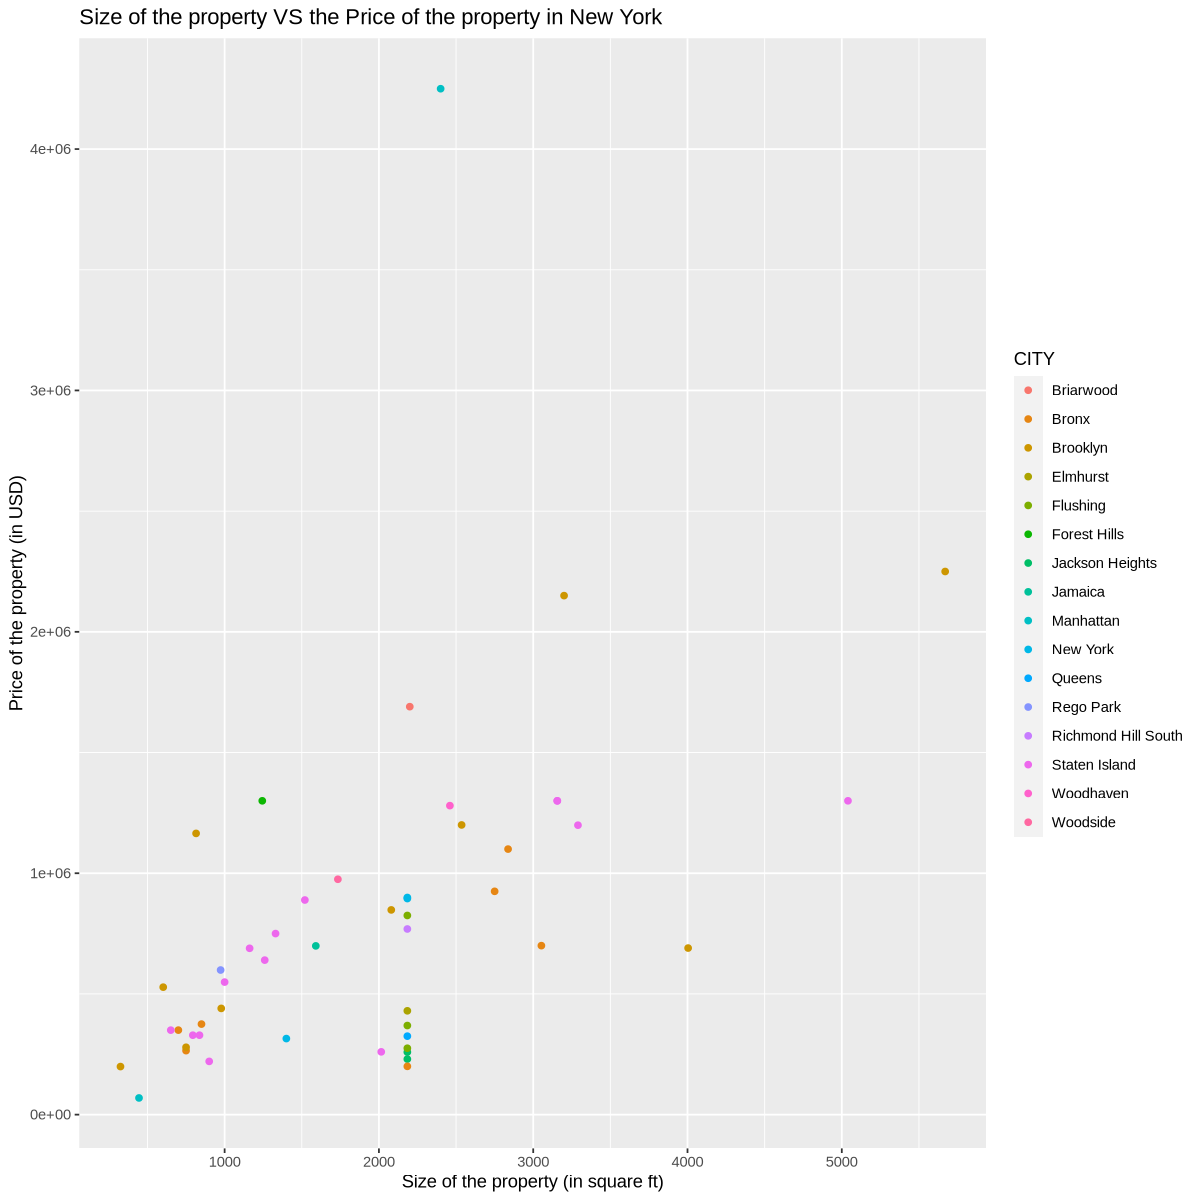

In [57]:
options(repr.plot.height = 10, repr.plot.width = 10)
price_sqft_plot <- newyork_tidy_sample |>
                ggplot(aes(x=PROPERTYSQFT, y=PRICE, color = CITY)) + #color later when figure out how to modify state
                geom_point() +
                labs(x="Size of the property (in square ft)", y= "Price of the property (in USD)") +
                ggtitle("Size of the property VS the Price of the property in New York")
price_sqft_plot

In [58]:
property_in_each_city_count <- newyork_tidy |>
                                group_by(CITY) |>
                                summarize(count = n()) |> 
                                arrange(desc(count))
property_in_each_city_count

CITY,count
<chr>,<int>
Brooklyn,1098
New York,739
Staten Island,507
Bronx,478
Manhattan,359
⋮,⋮
Canarsie,1
Ditmas Park,1
New Hyde Park,1


*After doing some preliminary data analysis of our dataset, we discovered that there are too many cities in which the property can be classified. To be exact, there are **69 cities** we can classify our data into within our dataset. Hence, we have decided to take the **10 cities with the most properties** from our dataset.*

In [59]:
top_10_cities <- c("Brooklyn", "New York", "Staten Island", "Bronx", "Manhattan", 
                           "Flushing", "Forest Hills", "Queens", "Jamaica", "Bayside")
newyork_subset <- newyork_tidy |>
                    filter(CITY %in% top_10_cities)
newyork_subset

TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,CITY
<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Condo for sale,315000,2,2,1400.000,New York
House for sale,260000,4,2,2015.000,Staten Island
Condo for sale,69000,3,1,445.000,Manhattan
House for sale,690000,5,2,4004.000,Brooklyn
Condo for sale,899500,2,2,2184.208,New York
⋮,⋮,⋮,⋮,⋮,⋮
Condo for sale,945000,2,2,903.000,Manhattan
Multi-family home for sale,2999999,15,9,3600.000,Brooklyn
Co-op for sale,599000,1,1,2184.208,Manhattan


In [60]:
newyork_subset <- newyork_subset |>
                    mutate(PricePerSQFT = PRICE / PROPERTYSQFT)
newyork_subset

TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,CITY,PricePerSQFT
<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Condo for sale,315000,2,2,1400.000,New York,225.0000
House for sale,260000,4,2,2015.000,Staten Island,129.0323
Condo for sale,69000,3,1,445.000,Manhattan,155.0562
House for sale,690000,5,2,4004.000,Brooklyn,172.3277
Condo for sale,899500,2,2,2184.208,New York,411.8198
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Condo for sale,945000,2,2,903.000,Manhattan,1046.5116
Multi-family home for sale,2999999,15,9,3600.000,Brooklyn,833.3331
Co-op for sale,599000,1,1,2184.208,Manhattan,274.2413


In [61]:
average_price_persqft <- newyork_subset |>
                            group_by(CITY) |> 
                            summarize(mean(PricePerSQFT)) 
average_price_persqft

CITY,mean(PricePerSQFT)
<chr>,<dbl>
Bayside,470.6947
Bronx,361.2235
Brooklyn,669.3502
Flushing,558.1174
Forest Hills,352.7798
Jamaica,359.5431
Manhattan,963.9923
New York,1120.5663
Queens,570.6776


In [65]:
ny_housing_split <- initial_split(newyork_subset, prop = 0.75, strata = CITY)
ny_housing_train <- training(ny_housing_split)
ny_housing_test <- testing(ny_housing_split)

In [66]:
glimpse(ny_housing_train)

Rows: 2,716
Columns: 7
$ TYPE         <chr> "Co-op for sale", "Co-op for sale", "Multi-family home fo…
$ PRICE        <dbl> 265000, 350000, 1100000, 700000, 199900, 699000, 825000, …
$ BEDS         <dbl> 1, 1, 6, 6, 1, 4, 2, 3, 5, 2, 7, 4, 3, 2, 5, 5, 3, 1, 5, …
$ BATH         <int> 1, 1, 3, 2, 1, 3, 2, 2, 1, 2, 3, 2, 2, 1, 2, 4, 2, 1, 4, …
$ PROPERTYSQFT <dbl> 750.000, 700.000, 2837.000, 3053.000, 2184.208, 1591.000,…
$ CITY         <chr> "Bronx", "Bronx", "Bronx", "Bronx", "Bronx", "Jamaica", "…
$ PricePerSQFT <dbl> 353.33333, 500.00000, 387.73352, 229.28267, 91.52059, 439…


In [67]:
glimpse(ny_housing_test)

Rows: 906
Columns: 7
$ TYPE         <chr> "Condo for sale", "Co-op for sale", "Co-op for sale", "To…
$ PRICE        <dbl> 899500, 440000, 375000, 689000, 549000, 1300000, 750000, …
$ BEDS         <dbl> 2, 2, 2, 3, 2, 2, 2, 5, 1, 1, 2, 2, 3, 4, 3, 3, 1, 1, 2, …
$ BATH         <int> 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 4, 4, 2, 1, 1, 2, …
$ PROPERTYSQFT <dbl> 2184.208, 978.000, 850.000, 1162.000, 1000.000, 1244.000,…
$ CITY         <chr> "New York", "Brooklyn", "Bronx", "Staten Island", "Staten…
$ PricePerSQFT <dbl> 411.8198, 449.8978, 441.1765, 592.9432, 549.0000, 1045.01…


In [68]:
city_proportions <- ny_housing_train |>
                      group_by(CITY) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(ny_housing_train))

city_proportions

CITY,n,percent
<chr>,<int>,<dbl>
Bayside,59,2.172312
Bronx,362,13.328424
Brooklyn,824,30.338733
Flushing,96,3.534610
Forest Hills,63,2.319588
Jamaica,51,1.877761
Manhattan,269,9.904271
New York,548,20.176730
Queens,65,2.393225


In [69]:
ny_housing_recipe <- recipe(CITY ~ PricePerSQFT + PROPERTYSQFT, data = ny_housing_train) |>
                      step_scale(all_predictors()) |>
                      step_center(all_predictors())

**Methods:**

This study analyzes a dataset containing information about properties in various cities in New York, including the type of property, price, number of bedrooms, number of bathrooms, property square footage, city, and price per square foot. The dataset includes a variety of property types, such as condos, houses, and co-ops, and covers different cities like New York, Manhattan, Brooklyn, and Staten Island. To analyze the data, we will first perform descriptive statistics to understand the distribution of the PRICE and PROPERTYSQFT and identify any outliers or missing values. Next, We will employ data visualization techniques, such as scatter plots and regression lines, to visually illustrate the relationship between housing prices and these factors across different cities. We will also use statistical tests, such as knn classification, to determine the strength and direction of the relationships between variables. Finally, we will build predictive models, such as linear regression, to predict property prices based on the available features and evaluate the performance of the models.

**Expected Outcomes and Significance:**